In [1]:
import torch
from kan import KAN as PyKAN
from kan.utils import create_dataset
from matplotlib import pyplot as plt
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Special function (sine integral)

In this test we consider the sine integral special function:

$$Si(x) = \int_0^x \frac{\sin(t)}{t} dt$$

This function cannot be represented as a composition of common functions and is therefore a special function. Unlike other symbolic regression algorithms, PyKAN is able to approximate it anyway, although the accuracy depends on the depth of the architecture.

For reasons of interpretability, we train a rather small network, foregoing high accuracy.

PyKAN can't learn it at all, while EfficientKAN seems to do the job, albeit with some noticeable loss.

## Dataset definition and plotting

In [2]:
steps = 1000
sine_integral = lambda x: torch.stack(
    [-torch.trapz(
        torch.sin(torch.linspace(0.000001, xi.item(), steps=steps)) /
        torch.linspace(0.000001, xi.item(), steps=steps), dx=xi.item() / steps
    ) for xi in x]
)

dataset = create_dataset(sine_integral, n_var=1, ranges=[-20, 20], train_num=5000, normalize_label=True,
                         normalize_input=True)

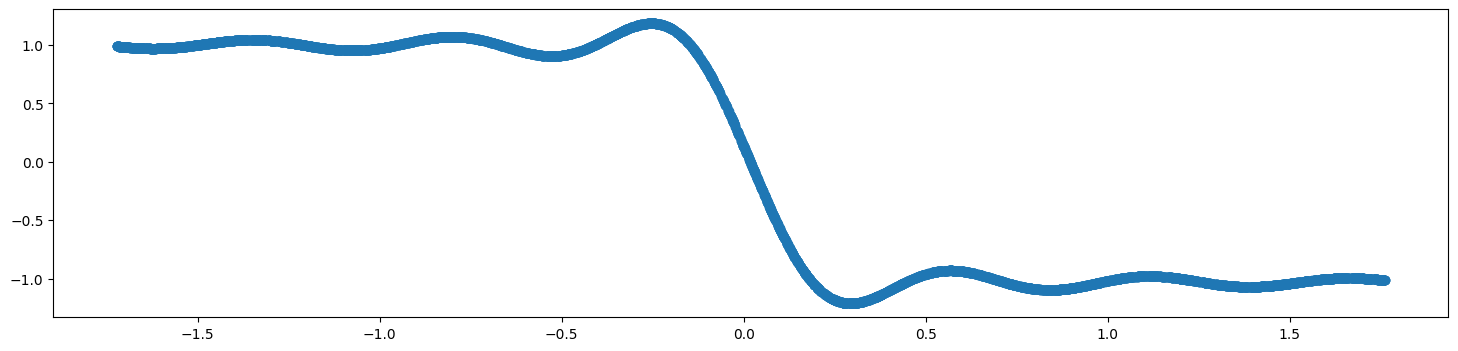

In [3]:
fig, ax = plt.subplots()
ax.scatter(dataset["train_input"].to('cpu'), dataset["train_label"].to('cpu'))
fig.set_size_inches(18, 4)
plt.show()

## PyKAN training

In [16]:
model = PyKAN(width=[1, 2, 2, 1], grid=3, k=3)
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.002, lamb_entropy=4)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.42e-02 | test_loss: 3.35e-02 | reg: 1.19e+01 | : 100%|█| 100/100 [01:03<00:00,  1.57

saving model version 0.1


### What did the PyKAN understand?
Providing a linespace to the model, we figure out how the KAN sees the learned function.

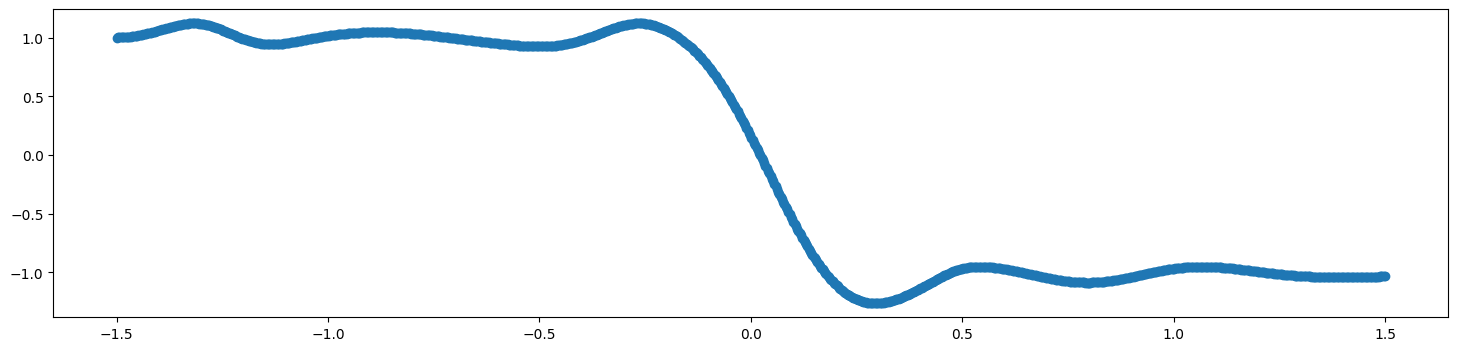

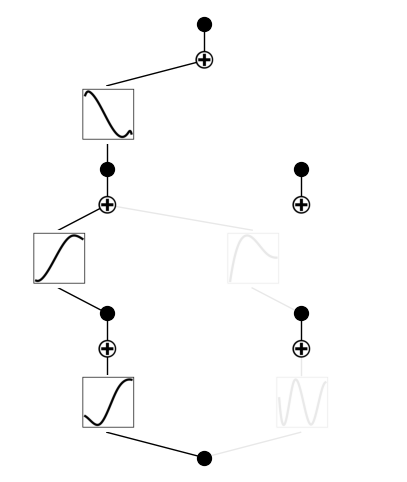

In [17]:
x_axis = torch.linspace(-1.5, 1.5, steps=steps)
y_axis = model(x_axis.view(-1, 1)).detach().numpy()
fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)
fig.set_size_inches(18, 4)
plt.show()
model.plot()

saving model version 0.2
r2 is 0.9981340765953064
saving model version 0.2
r2 is 0.9997779726982117
saving model version 0.3
Best value at boundary.
r2 is 0.9881991147994995
saving model version 0.4


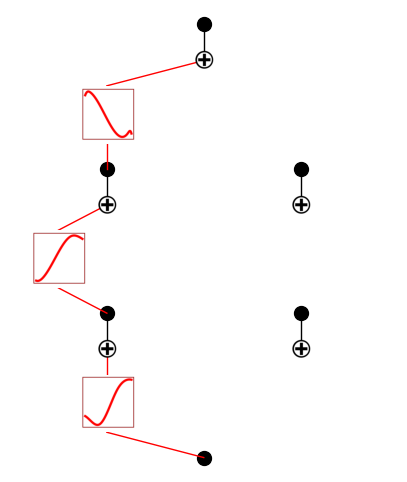

In [19]:
model.prune(node_th=1e-1,edge_th=1e-1)
model.fix_symbolic(0,0,0, 'sin')
model.fix_symbolic(1,0,0, 'sin')
model.fix_symbolic(2,0,0,'cos')
model.plot()
pass

# EfficientKAN
We conclude this test proving that EfficientKAN can also reach great accuracy.

In [152]:
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=200):
        super(Efficient_KAN, self).__init__()
        self.layers = [1, 1]
        self.model = EffKAN(self.layers,
                            grid_size=grid_size,
                            # grid_eps=1,
                            # scale_base=0,
                            # sp_trainable=False,
                            # sb_trainable=False,
                            # enable_standalone_scale_spline=False
                            ).to(device)
        self.double()

    def forward(self, x):
        # x = x / dataset_size * 2 - 1
        # x = x.view(-1, self.layers[0])
        x = self.model(x)
        return x

In [133]:
def train(model, optimizer, inputs: torch.Tensor, labels, epochs=5, batch_size=100):
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    for epoch in range(epochs):
        model.train()
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size].to(device)
                y = labels[i * batch_size:(i + 1) * batch_size].to(device)
                optimizer.zero_grad()
                output = model(x)
                output = output.squeeze()
                loss = criterion(output, y.double())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
                scheduler.step()

In [177]:
model2 = Efficient_KAN(grid_size=20)
train(model2, optim.Adam(model2.parameters(), lr=0.025), dataset["train_input"], dataset["train_label"], epochs=20,
      batch_size=100)

100%|██████████| 50/50 [00:00<00:00, 208.86it/s, loss=0.115, lr=0.00338] 


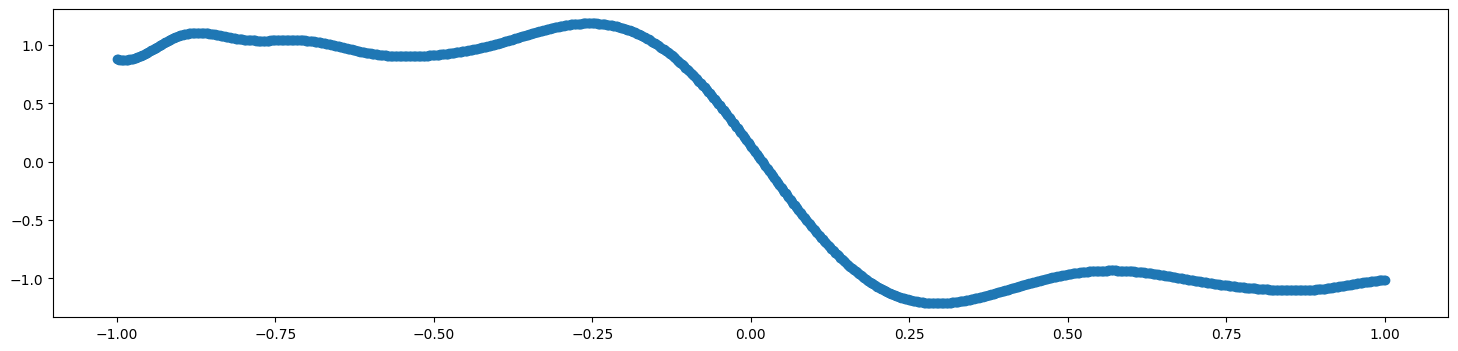

In [178]:
x_axis = torch.linspace(-1, 1, steps=steps)
y_axis = model2(x_axis.to('cuda').view(-1, 1)).to('cpu').detach().numpy()
fig, ax = plt.subplots()
ax.scatter(x_axis, y_axis)
fig.set_size_inches(18, 4)
plt.show()